https://www.w3cschool.cn/pytorch/pytorch-w18e3be1.html

#
特别对于视觉方面，我们创建了一个包，名字叫torchvision，其中包含了针对Imagenet、CIFAR10、MNIST 等常用数据集的数据加载器 (data loaders），还有对图像数据转换的操作，即torchvision.datasets和torch.utils.data.DataLoader。

这提供了极大的便利，可以避免编写样板代码。

在这个教程中，我们将使用CIFAR10数据集，它有如下的分类：“飞机”，“汽车”，“鸟”，“猫”，“鹿”，“狗”，“青蛙”，“马”，“船”，“卡车”等。在CIFAR-10里面的图片数据大小是3x32x32，即：三通道彩色图像，图像大小是32x32像素。

训练一个图片分类器
我们将按顺序做以下步骤：

通过torchvision加载CIFAR10里面的训练和测试数据集，并对数据进行标准化
定义卷积神经网络
定义损失函数
利用训练数据训练网络
利用测试数据测试网络

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [11]:
#torchvision 数据集加载完后的输出是范围在 [ 0, 1 ] 之间的 PILImage。我们将其标准化为范围在 [ -1, 1 ] 之间的张量。
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

path = "D:/BaiduNetdiskDownload/data/"
#path = "./data/"
#trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainset = torchvision.datasets.CIFAR10(root=path, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
#trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,  drop_last = False)

#testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root=path, train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


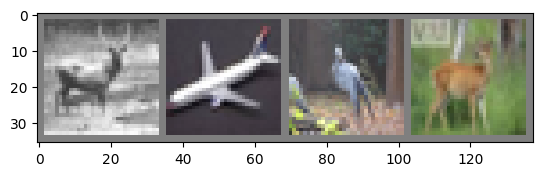

 deer plane  bird  deer


In [12]:
import matplotlib.pyplot as plt
import numpy as np
## 输出图像的函数
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
## 随机获取训练图片
dataiter = iter(trainloader)
images, labels = next(dataiter)
## 显示图片
imshow(torchvision.utils.make_grid(images))
## 打印图片标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [13]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.222
[1,  4000] loss: 1.862
[1,  6000] loss: 1.688
[1,  8000] loss: 1.597
[1, 10000] loss: 1.506
[1, 12000] loss: 1.481
[2,  2000] loss: 1.411
[2,  4000] loss: 1.381
[2,  6000] loss: 1.349
[2,  8000] loss: 1.303
[2, 10000] loss: 1.294
[2, 12000] loss: 1.278
Finished Training


In [14]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

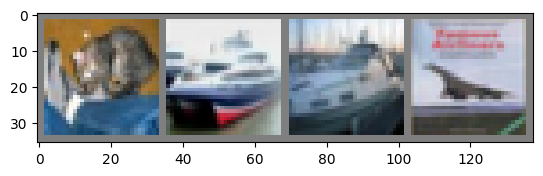

GroundTruth:    cat  ship  ship plane


In [15]:
dataiter = iter(testloader)
images, labels = next(dataiter)
## 输出图片
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

In [16]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat   car   car plane


In [17]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 51 %


In [18]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 49 %
Accuracy of   car : 58 %
Accuracy of  bird : 53 %
Accuracy of   cat : 17 %
Accuracy of  deer : 42 %
Accuracy of   dog : 65 %
Accuracy of  frog : 61 %
Accuracy of horse : 69 %
Accuracy of  ship : 52 %
Accuracy of truck : 46 %
